In [ ]:
# from google.colab import drive

# # This will prompt you to click a link and get an authorization code
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install catboost


In [ ]:
!pip install tsfresh


# Selecting data

In [ ]:
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy import stats
from scipy.signal import find_peaks
import numpy as np
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from sklearn.metrics import make_scorer, mean_absolute_error


from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import EfficientFCParameters, MinimalFCParameters


os.chdir("/content/gdrive/MyDrive/DMP")
pd.set_option("display.precision", 2)

In [ ]:
people = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P17']
columns_needed = ["Delta_Time", "MET", "value__bpm", "Time[s]"]

def time_lagged_features(data, time_lags):
    for time_lag in time_lags:
        data['valuebpm_lag_b_{}'.format(time_lag)] = data['valuebpm'].shift(time_lag)
        data['valuebpm_lag_b_{}'.format(time_lag)].fillna(method='bfill', inplace=True)

        # Now create the forward lagged features
        data['valuebpm_lag_f_{}'.format(time_lag)] = data['valuebpm'].shift(-time_lag)
        data['valuebpm_lag_f_{}'.format(time_lag)].fillna(method='ffill', inplace=True)
    return data

time_lagged_features_enabled = True

data = []
for person in people:
    df = pd.read_pickle("merged_dataset/{0}/ALL.pkl".format(person))
    df_subset = df[columns_needed]
    df_subset.ffill(inplace=True)
    df_subset.bfill(inplace=True)
    df_subset.rename(columns={"value__bpm": "valuebpm"}, inplace=True)
    if time_lagged_features_enabled:
        time_lags = [x for x in range(1, 15, 2)]
        df_subset = time_lagged_features(df_subset, time_lags)
    # columns_needed = columns_needed + [col for col in data[0].columns if 'lag' in col]

    coulms_feature_eng = ["valuebpm", "Time[s]"]
    features = extract_features(df_subset[coulms_feature_eng], column_id='Time[s]',
                                 default_fc_parameters=MinimalFCParameters(),
                                 n_jobs=4)


    # Merge features back into the original DataFrame
    df_subset = df_subset.merge(features, left_on='Time[s]', right_index=True)

    df_subset['Person'] = person
    data.append(df_subset)

print(data[0])

<ipython-input-67-a62e69f9fe55>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.ffill(inplace=True)
<ipython-input-67-a62e69f9fe55>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.bfill(inplace=True)
<ipython-input-67-a62e69f9fe55>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset.rename(columns={"value__bpm": "valuebpm"}, inplace=True)
<ipython-input-67-a62e69f9fe55>:6: SettingWithCopyWarning: 
A valu

                         Delta_Time   MET  valuebpm  Time[s]  \
Time                                                           
2021-12-03 16:58:51 0 days 00:00:00  1.31      91.0      1.0   
2021-12-03 16:58:52 0 days 00:00:01  1.31      91.0      2.0   
2021-12-03 16:58:53 0 days 00:00:02  1.52      91.0      3.0   
2021-12-03 16:58:54 0 days 00:00:03  1.63      91.0      4.0   
2021-12-03 16:58:55 0 days 00:00:04  1.56      88.0      5.0   
...                             ...   ...       ...      ...   
2021-12-03 17:28:48 0 days 00:29:57  5.32     139.0   1798.0   
2021-12-03 17:28:49 0 days 00:29:58  5.11     139.0   1799.0   
2021-12-03 17:28:50 0 days 00:29:59  4.46     142.0   1800.0   
2021-12-03 17:28:51 0 days 00:30:00  4.12     142.0   1801.0   
2021-12-03 17:28:52 0 days 00:30:01  4.43     142.0   1802.0   

                     valuebpm_lag_b_1  valuebpm_lag_f_1  valuebpm_lag_b_3  \
Time                                                                        
2021-12-03 16

In [ ]:
data[0].columns

Index(['Delta_Time', 'MET', 'valuebpm', 'Time[s]', 'valuebpm_lag_b_1',
       'valuebpm_lag_f_1', 'valuebpm_lag_b_3', 'valuebpm_lag_f_3',
       'valuebpm_lag_b_5', 'valuebpm_lag_f_5', 'valuebpm_lag_b_7',
       'valuebpm_lag_f_7', 'valuebpm_lag_b_9', 'valuebpm_lag_f_9',
       'valuebpm_lag_b_11', 'valuebpm_lag_f_11', 'valuebpm_lag_b_13',
       'valuebpm_lag_f_13', 'valuebpm__sum_values', 'valuebpm__median',
       'valuebpm__mean', 'valuebpm__length', 'valuebpm__standard_deviation',
       'valuebpm__variance', 'valuebpm__root_mean_square', 'valuebpm__maximum',
       'valuebpm__absolute_maximum', 'valuebpm__minimum', 'Person'],
      dtype='object')

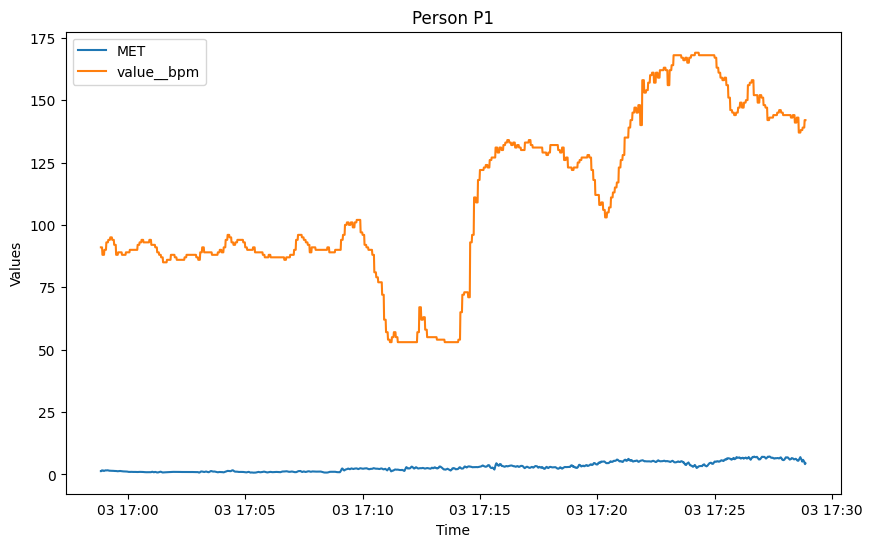

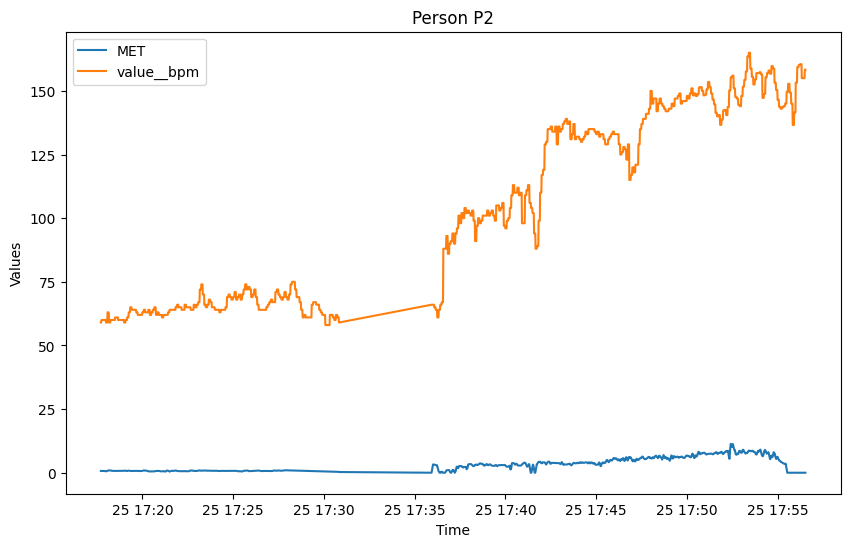

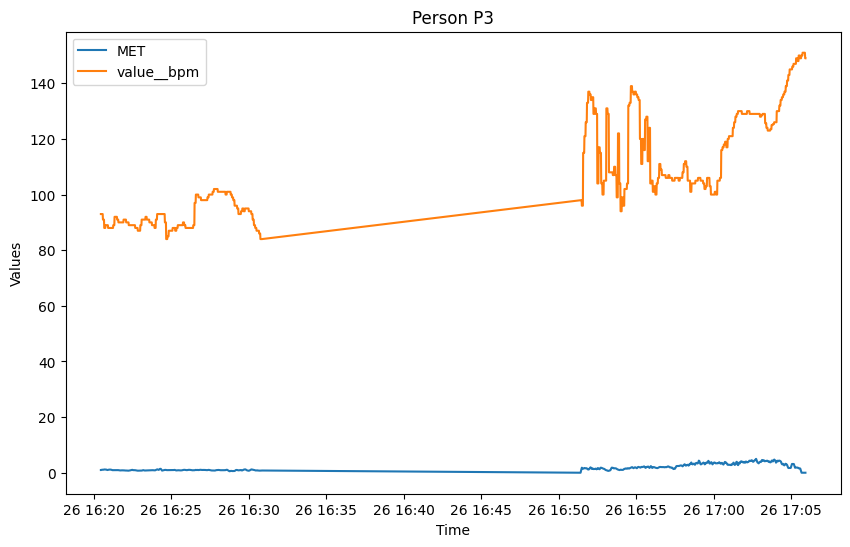

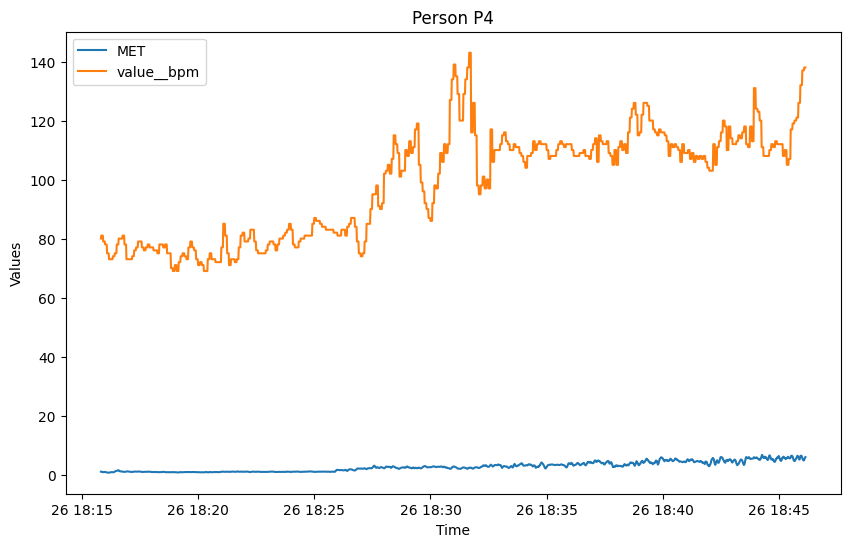

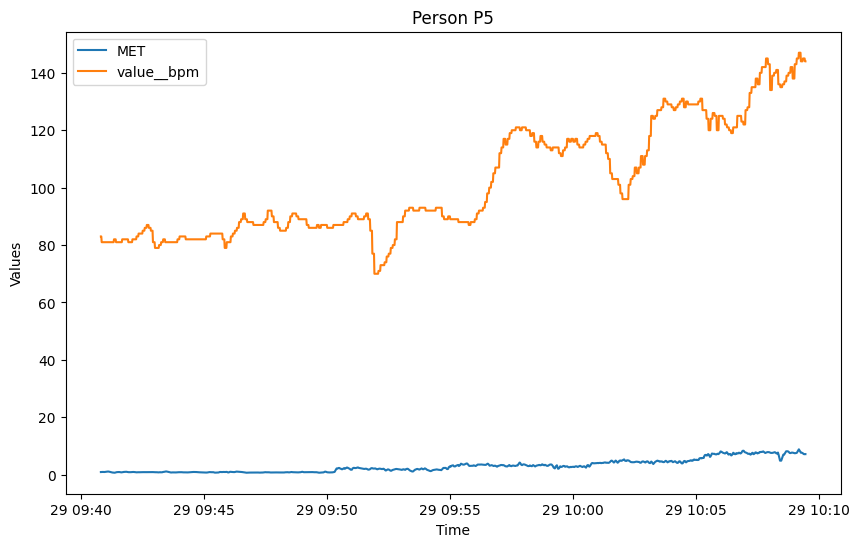

In [ ]:
import matplotlib.pyplot as plt

# Iterate over the data list
for i, df_subset in enumerate(data):
  if i < 5:
    person = people[i]

    # Extract MET and value__bpm columns
    MET = df_subset['MET']
    value_bpm = df_subset['valuebpm'].ffill()

    # Plot MET and value__bpm
    plt.figure(figsize=(10, 6))
    plt.plot(MET, label='MET')
    plt.plot(value_bpm, label='value__bpm')
    plt.title(f'Person {person}')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend()
    plt.show()


##Checking whether there are null values

In [ ]:
null_counts_per_df = {}

# Iterate through each DataFrame in the list
for idx, df in enumerate(data):
    # Count null values in each column of the DataFrame
    null_counts_per_df[idx] = df.isnull().sum()

# Print null counts for each DataFrame
for idx, null_counts in null_counts_per_df.items():
    print(f"Null counts for DataFrame {idx}:")
    print(null_counts)

Null counts for DataFrame 0:
Delta_Time                      0
MET                             0
valuebpm                        0
Time[s]                         0
valuebpm_lag_b_1                0
valuebpm_lag_f_1                0
valuebpm_lag_b_3                0
valuebpm_lag_f_3                0
valuebpm_lag_b_5                0
valuebpm_lag_f_5                0
valuebpm_lag_b_7                0
valuebpm_lag_f_7                0
valuebpm_lag_b_9                0
valuebpm_lag_f_9                0
valuebpm_lag_b_11               0
valuebpm_lag_f_11               0
valuebpm_lag_b_13               0
valuebpm_lag_f_13               0
valuebpm__sum_values            0
valuebpm__median                0
valuebpm__mean                  0
valuebpm__length                0
valuebpm__standard_deviation    0
valuebpm__variance              0
valuebpm__root_mean_square      0
valuebpm__maximum               0
valuebpm__absolute_maximum      0
valuebpm__minimum               0
Person             

## Model training

In [ ]:

concatenated_data = pd.concat(data, axis=0)
data_new = concatenated_data.copy()

X_data = data_new.drop(columns=["Delta_Time", "MET", "Time[s]", "Person"]).copy()
print(X_data.columns)
X_data = X_data.to_numpy()

Y_data = concatenated_data['MET']
Y_data = Y_data.to_numpy()
people = concatenated_data['Person']

Index(['valuebpm', 'valuebpm_lag_b_1', 'valuebpm_lag_f_1', 'valuebpm_lag_b_3',
       'valuebpm_lag_f_3', 'valuebpm_lag_b_5', 'valuebpm_lag_f_5',
       'valuebpm_lag_b_7', 'valuebpm_lag_f_7', 'valuebpm_lag_b_9',
       'valuebpm_lag_f_9', 'valuebpm_lag_b_11', 'valuebpm_lag_f_11',
       'valuebpm_lag_b_13', 'valuebpm_lag_f_13', 'valuebpm__sum_values',
       'valuebpm__median', 'valuebpm__mean', 'valuebpm__length',
       'valuebpm__standard_deviation', 'valuebpm__variance',
       'valuebpm__root_mean_square', 'valuebpm__maximum',
       'valuebpm__absolute_maximum', 'valuebpm__minimum'],
      dtype='object')


In [ ]:
normalizer = MinMaxScaler()
X_data = normalizer.fit_transform(X_data)

### XGBoost with cross validation

#### Cross validation

In [ ]:
group_kfold = GroupKFold(n_splits=17)
cv = [split for split in group_kfold.split(X_data, Y_data, people)]
cv = sorted(cv, key=lambda x: x[1][0], reverse=False)

In [ ]:
for i,group in enumerate(cv):
    print(f"Fold {i}")
    print(f"Train size: {group[0].size}")
    print(f"Test size: {group[1].size}")
    print(f"Train participants: {people.iloc[group[0]].unique()}")
    print(f"Test participants: {people.iloc[group[1]].unique()}")

Fold 0
Train size: 25854
Test size: 1802
Train participants: ['P2' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P1']
Fold 1
Train size: 25630
Test size: 2026
Train participants: ['P1' 'P3' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P2']
Fold 2
Train size: 26159
Test size: 1497
Train participants: ['P1' 'P2' 'P4' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P3']
Fold 3
Train size: 25836
Test size: 1820
Train participants: ['P1' 'P2' 'P3' 'P5' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P4']
Fold 4
Train size: 25937
Test size: 1719
Train participants: ['P1' 'P2' 'P3' 'P4' 'P6' 'P7' 'P8' 'P9' 'P10' 'P11' 'P12' 'P13' 'P14'
 'P15' 'P16' 'P17']
Test participants: ['P5']
Fold 5
Train size: 26006
Test size: 1650
Train participants: ['P1' 'P2' 'P3' 'P4' 'P5' 'P7' 'P8' 'P9' 'P10' 'P

In [ ]:


# Define the parameters grid
parameters_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create XGBRegressor model
model = XGBRegressor(colsample_bytree=0.56, subsample=0.3, min_child_weight=0.6)

# Define mean absolute error as scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform grid search with custom CV splitter
grid_search = GridSearchCV(model, parameters_grid, cv = cv, scoring=scorer, n_jobs=-1)
grid_search.fit(X_data, Y_data)

# Get results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean absolute error found:", -grid_search.best_score_)


Best parameters found:
{'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 500}
Best mean absolute error found: 1.055430484890577


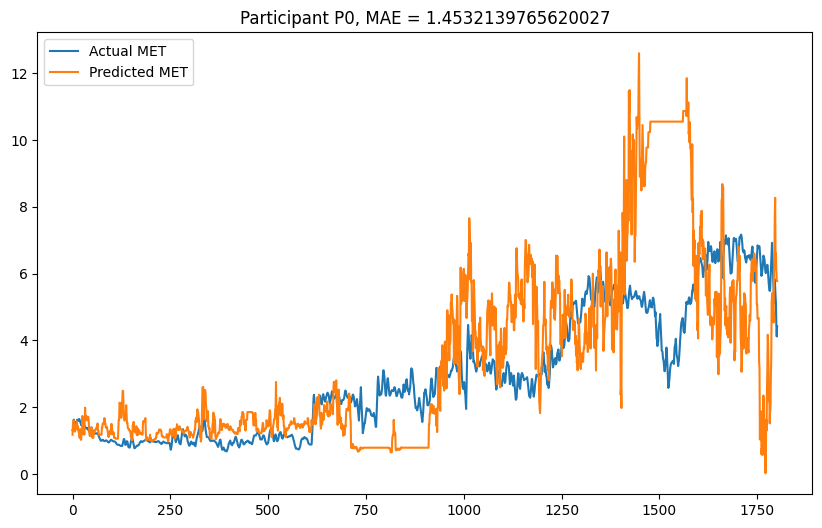

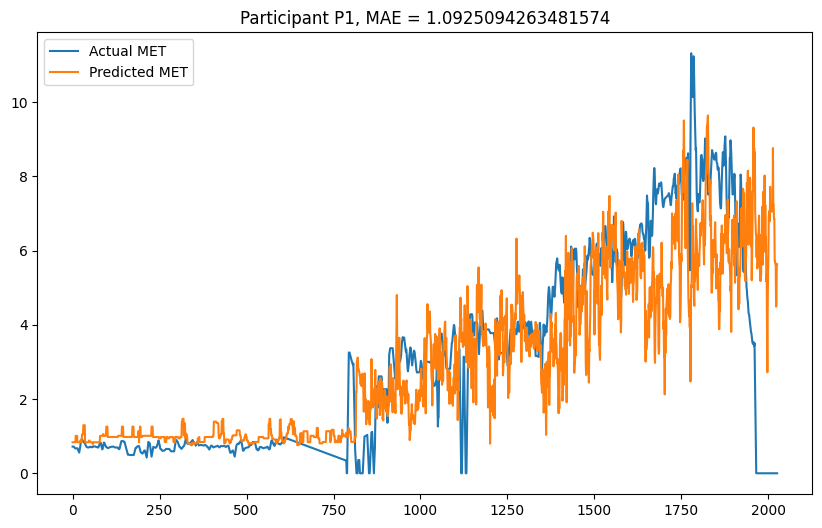

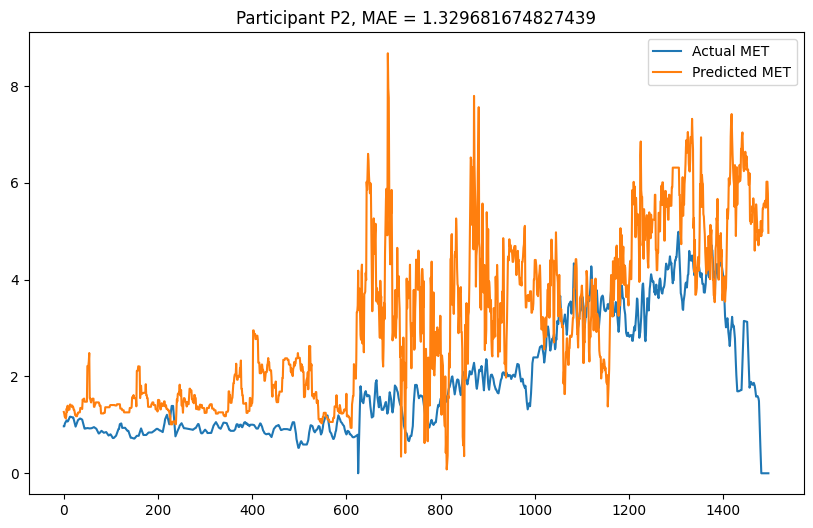

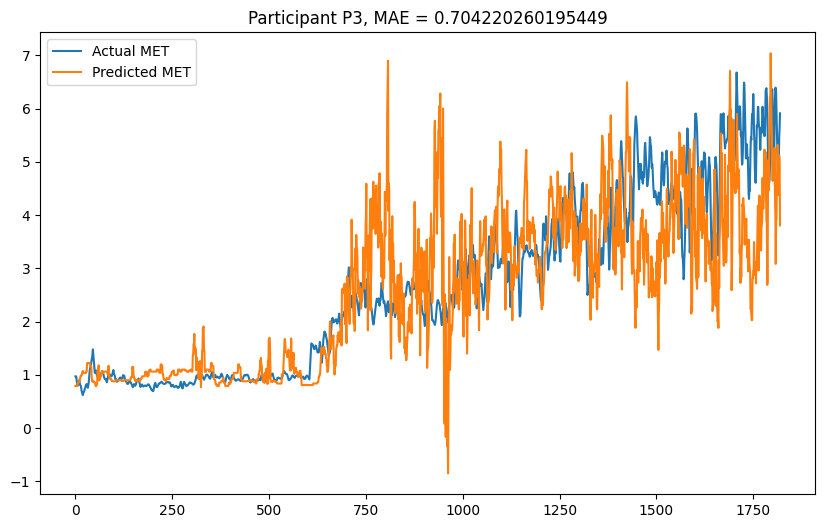

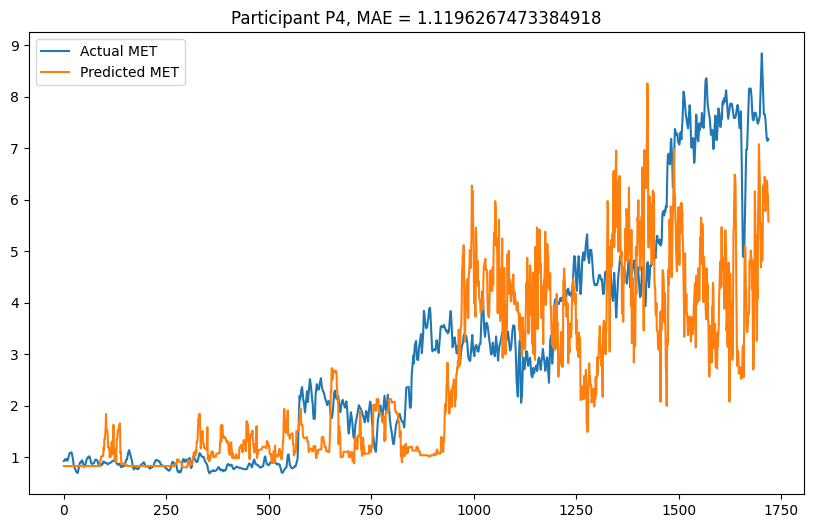

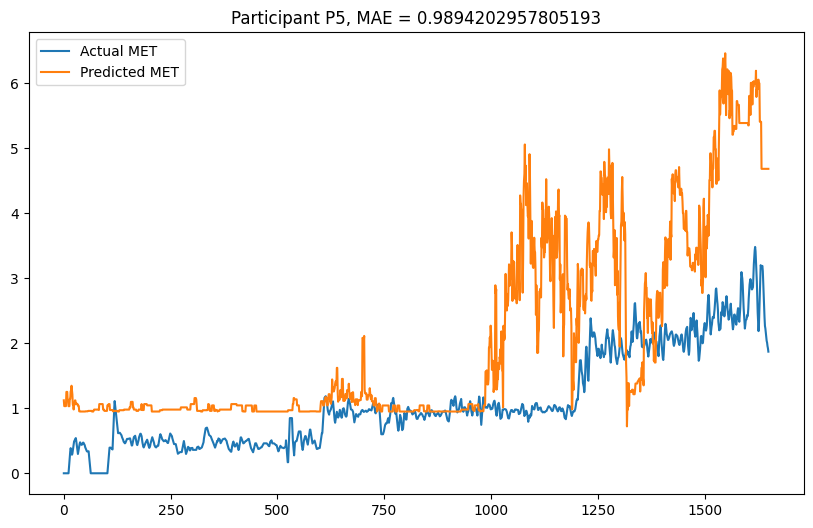

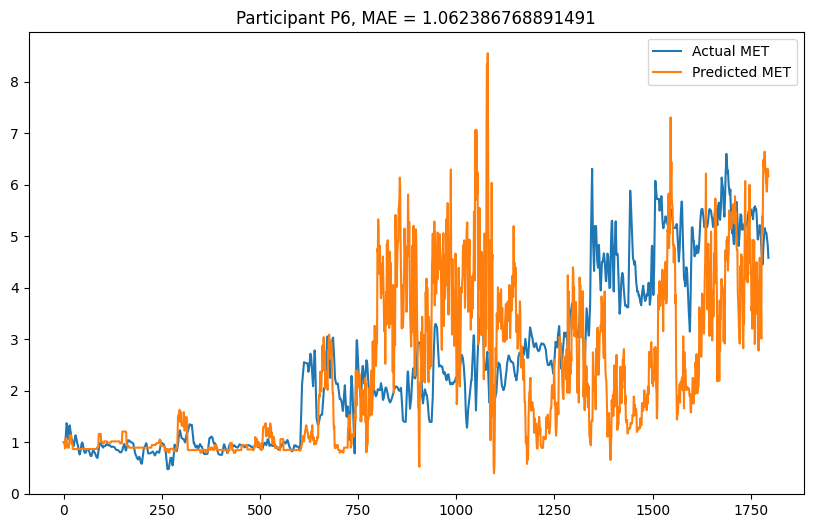

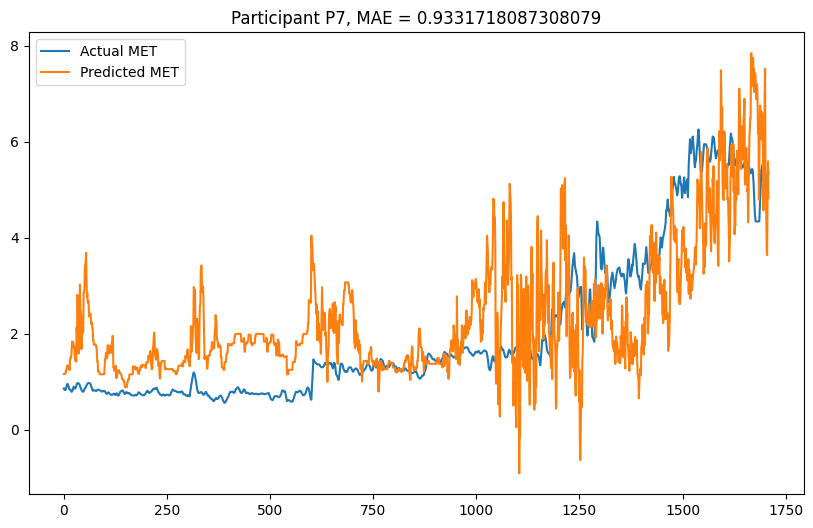

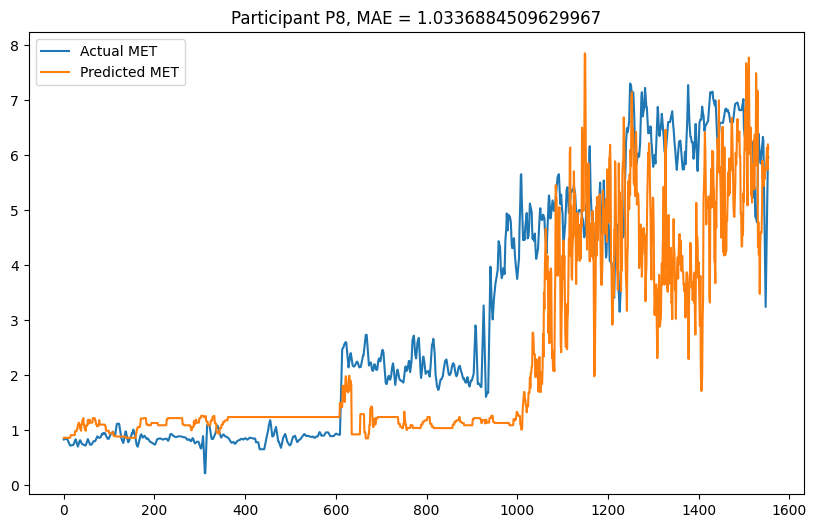

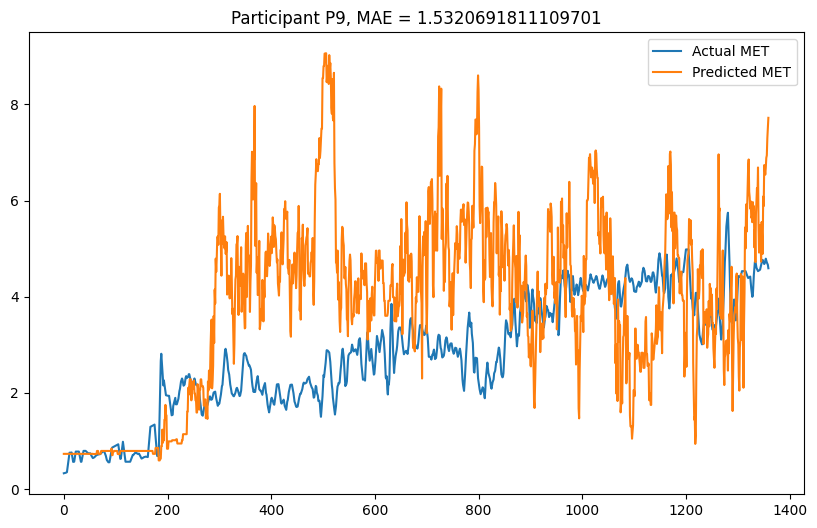

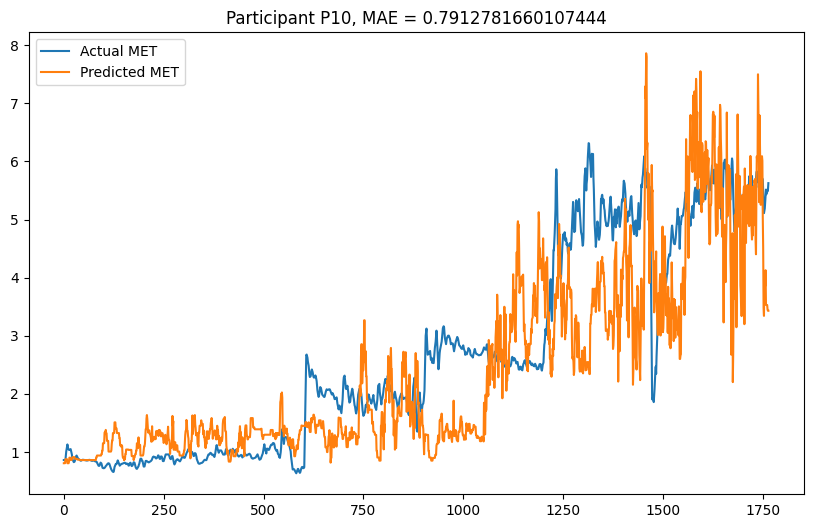

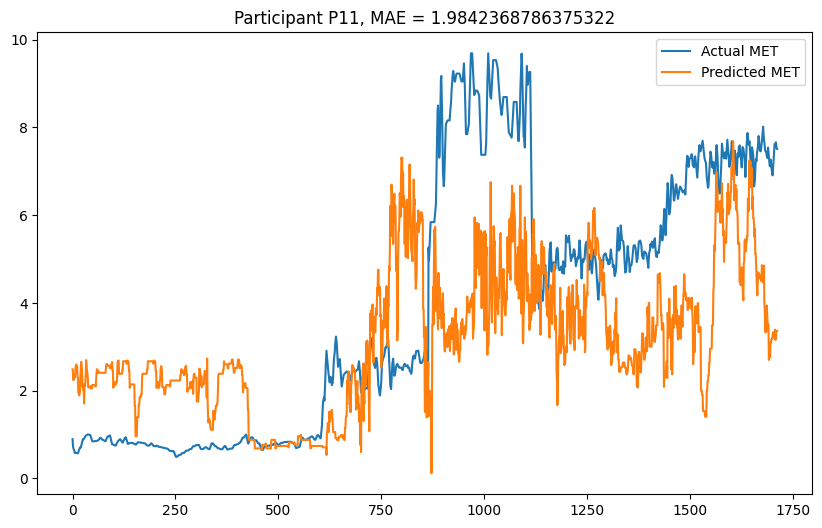

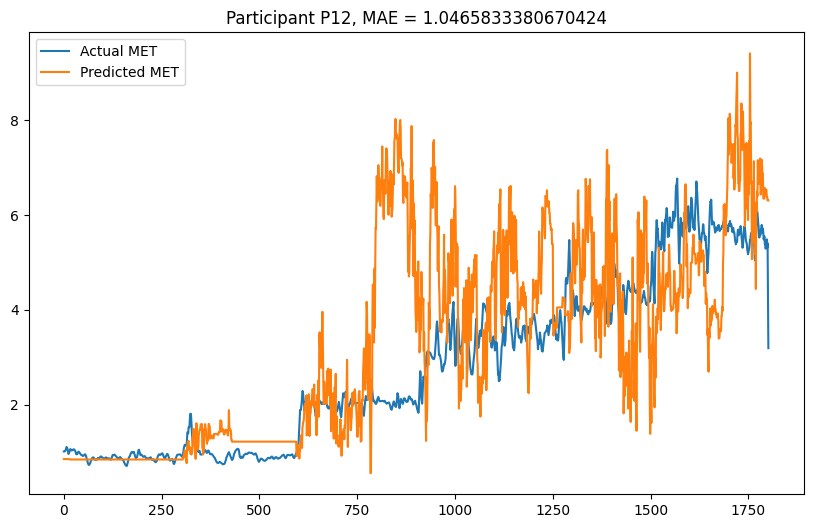

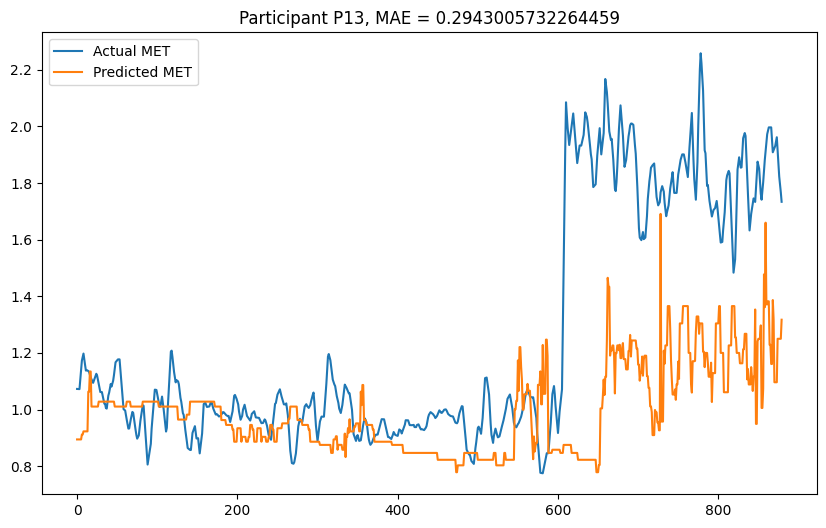

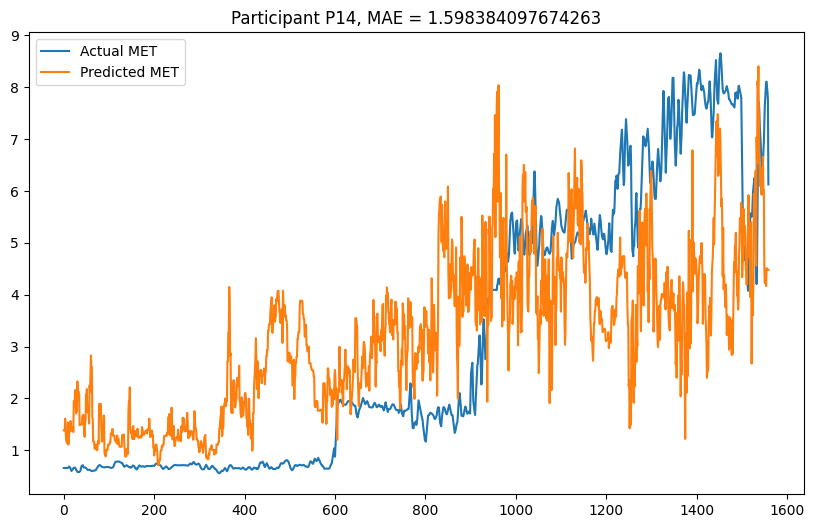

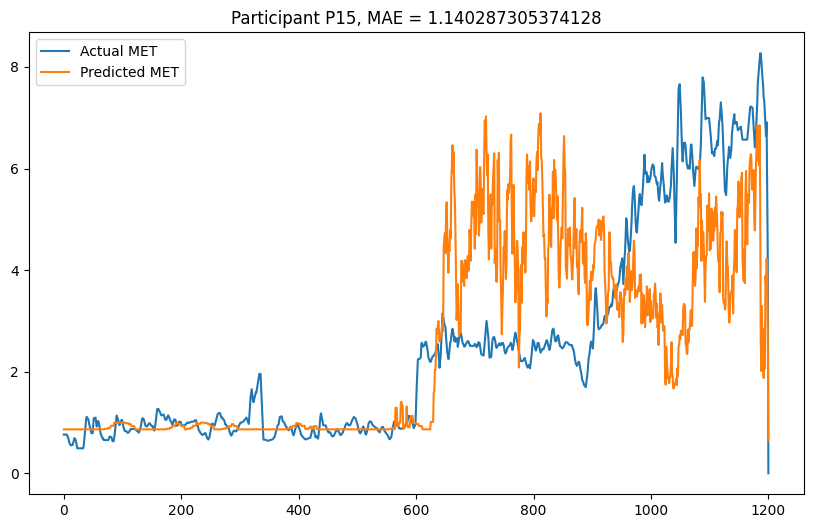

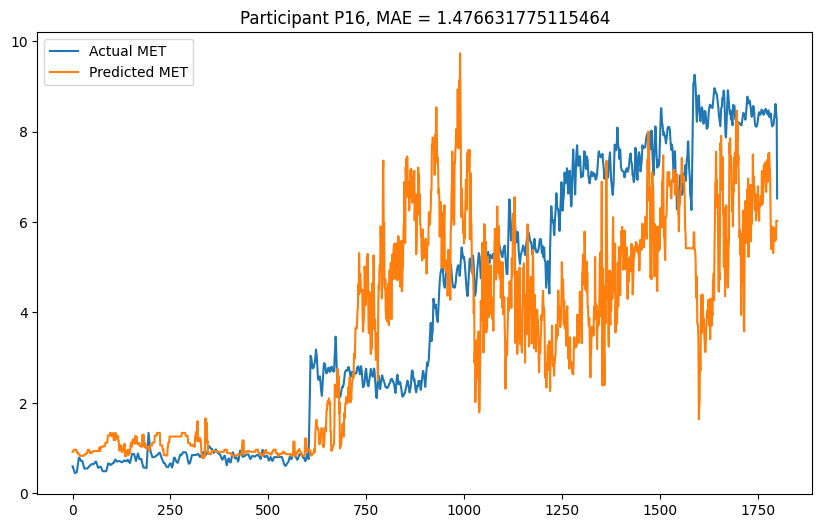

In [ ]:
mae_list_xgboost =[]
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    # print(train_index, test_index)
    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]
    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)
    mae = mean_absolute_error(Y_test, Y_pred)
    mae_list_xgboost.append((fold + 1,mae))
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant P{}, MAE = {}'.format(fold, mae))
    plt.legend()
    plt.show()

In [ ]:
mae_list_xgboost

[(1, 1.4532139765620027),
 (2, 1.0925094263481574),
 (3, 1.329681674827439),
 (4, 0.704220260195449),
 (5, 1.1196267473384918),
 (6, 0.9894202957805193),
 (7, 1.062386768891491),
 (8, 0.9331718087308079),
 (9, 1.0336884509629967),
 (10, 1.5320691811109701),
 (11, 0.7912781660107444),
 (12, 1.9842368786375322),
 (13, 1.0465833380670424),
 (14, 0.2943005732264459),
 (15, 1.598384097674263),
 (16, 1.140287305374128),
 (17, 1.476631775115464)]

#CatBoost with cross validation

In [ ]:

parameters_grid = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [2, 3, 4, 5, 6]
}

# Create CatBoostRegressor model
model = CatBoostRegressor()

# Define GroupKFold for cross-validation
group_kfold = GroupKFold(n_splits=17)

# Define mean absolute error as scoring metric
scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Perform grid search
grid_search = GridSearchCV(model, parameters_grid, cv= cv, scoring=scorer, n_jobs=-1)
grid_search.fit(X_data, Y_data)

# Get results
print("Best parameters found:")
print(grid_search.best_params_)
print("Best mean absolute error found:", -grid_search.best_score_)


0:	learn: 2.1426396	total: 11.4ms	remaining: 5.68s
1:	learn: 2.1309844	total: 22ms	remaining: 5.47s
2:	learn: 2.1196466	total: 29.6ms	remaining: 4.91s
3:	learn: 2.1083254	total: 38.4ms	remaining: 4.77s
4:	learn: 2.0971649	total: 45.8ms	remaining: 4.54s
5:	learn: 2.0861946	total: 53.7ms	remaining: 4.42s
6:	learn: 2.0752514	total: 63.2ms	remaining: 4.45s
7:	learn: 2.0645600	total: 73ms	remaining: 4.49s
8:	learn: 2.0540684	total: 85ms	remaining: 4.64s
9:	learn: 2.0436094	total: 96.1ms	remaining: 4.71s
10:	learn: 2.0333768	total: 108ms	remaining: 4.82s
11:	learn: 2.0232117	total: 119ms	remaining: 4.83s
12:	learn: 2.0131458	total: 127ms	remaining: 4.77s
13:	learn: 2.0032555	total: 138ms	remaining: 4.8s
14:	learn: 1.9935311	total: 150ms	remaining: 4.85s
15:	learn: 1.9839579	total: 162ms	remaining: 4.9s
16:	learn: 1.9744820	total: 173ms	remaining: 4.92s
17:	learn: 1.9651001	total: 185ms	remaining: 4.95s
18:	learn: 1.9557991	total: 206ms	remaining: 5.2s
19:	learn: 1.9465645	total: 217ms	remain

P1
Learning rate set to 0.068448
0:	learn: 2.0871886	total: 14.7ms	remaining: 14.7s
1:	learn: 2.0104094	total: 24.4ms	remaining: 12.2s
2:	learn: 1.9412031	total: 34.9ms	remaining: 11.6s
3:	learn: 1.8776490	total: 44.3ms	remaining: 11s
4:	learn: 1.8206234	total: 54.8ms	remaining: 10.9s
5:	learn: 1.7689648	total: 76.2ms	remaining: 12.6s
6:	learn: 1.7247271	total: 93.7ms	remaining: 13.3s
7:	learn: 1.6833243	total: 103ms	remaining: 12.8s
8:	learn: 1.6467140	total: 112ms	remaining: 12.4s
9:	learn: 1.6131171	total: 122ms	remaining: 12.1s
10:	learn: 1.5831579	total: 132ms	remaining: 11.8s
11:	learn: 1.5569517	total: 141ms	remaining: 11.6s
12:	learn: 1.5332224	total: 153ms	remaining: 11.6s
13:	learn: 1.5131758	total: 165ms	remaining: 11.6s
14:	learn: 1.4954160	total: 175ms	remaining: 11.5s
15:	learn: 1.4781736	total: 184ms	remaining: 11.3s
16:	learn: 1.4636077	total: 197ms	remaining: 11.4s
17:	learn: 1.4499903	total: 211ms	remaining: 11.5s
18:	learn: 1.4387500	total: 220ms	remaining: 11.4s
19:

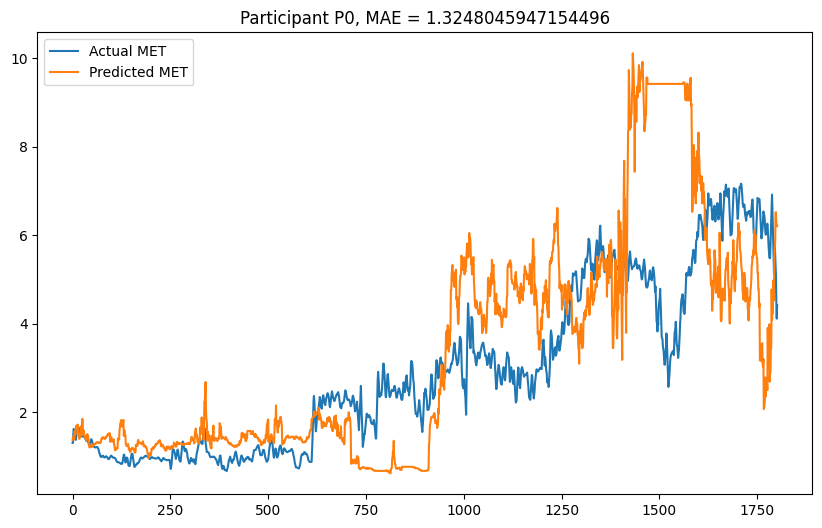

P1
Learning rate set to 0.068354
0:	learn: 2.0259399	total: 11.8ms	remaining: 11.8s
1:	learn: 1.9528959	total: 20.6ms	remaining: 10.3s
2:	learn: 1.8859418	total: 31ms	remaining: 10.3s
3:	learn: 1.8257124	total: 41.1ms	remaining: 10.2s
4:	learn: 1.7708368	total: 50.1ms	remaining: 9.96s
5:	learn: 1.7210969	total: 59ms	remaining: 9.77s
6:	learn: 1.6787236	total: 68ms	remaining: 9.64s
7:	learn: 1.6386209	total: 77.1ms	remaining: 9.56s
8:	learn: 1.6046713	total: 86.1ms	remaining: 9.48s
9:	learn: 1.5733296	total: 95.3ms	remaining: 9.44s
10:	learn: 1.5449862	total: 107ms	remaining: 9.59s
11:	learn: 1.5191094	total: 116ms	remaining: 9.58s
12:	learn: 1.4973416	total: 132ms	remaining: 9.99s
13:	learn: 1.4776672	total: 140ms	remaining: 9.89s
14:	learn: 1.4599529	total: 150ms	remaining: 9.84s
15:	learn: 1.4427001	total: 159ms	remaining: 9.79s
16:	learn: 1.4275074	total: 169ms	remaining: 9.77s
17:	learn: 1.4153862	total: 179ms	remaining: 9.75s
18:	learn: 1.4037966	total: 188ms	remaining: 9.73s
19:	

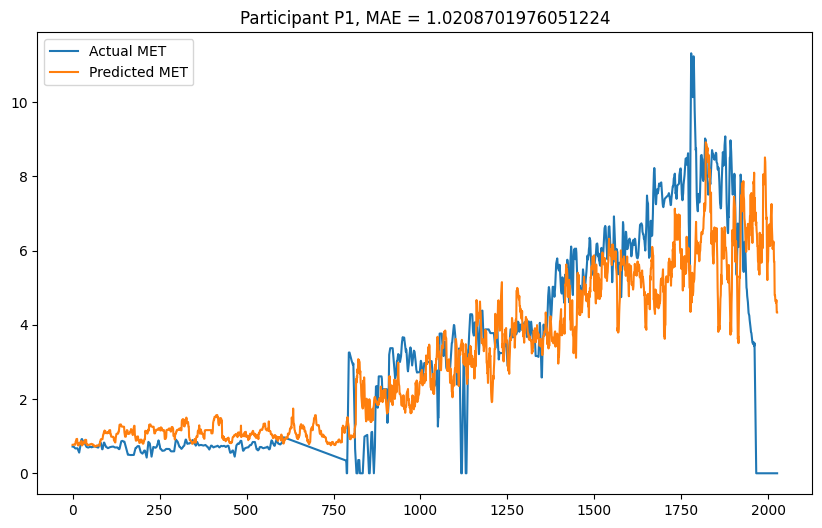

P1
Learning rate set to 0.068575
0:	learn: 2.0984834	total: 15.6ms	remaining: 15.6s
1:	learn: 2.0175102	total: 26ms	remaining: 13s
2:	learn: 1.9439398	total: 35.6ms	remaining: 11.8s
3:	learn: 1.8769022	total: 44.9ms	remaining: 11.2s
4:	learn: 1.8170498	total: 54.3ms	remaining: 10.8s
5:	learn: 1.7625677	total: 63.4ms	remaining: 10.5s
6:	learn: 1.7151424	total: 72.6ms	remaining: 10.3s
7:	learn: 1.6717907	total: 81.6ms	remaining: 10.1s
8:	learn: 1.6331329	total: 90.6ms	remaining: 9.97s
9:	learn: 1.5979414	total: 102ms	remaining: 10.1s
10:	learn: 1.5670284	total: 111ms	remaining: 9.98s
11:	learn: 1.5397547	total: 120ms	remaining: 9.85s
12:	learn: 1.5140020	total: 129ms	remaining: 9.78s
13:	learn: 1.4927132	total: 138ms	remaining: 9.7s
14:	learn: 1.4739170	total: 148ms	remaining: 9.69s
15:	learn: 1.4559962	total: 164ms	remaining: 10.1s
16:	learn: 1.4410561	total: 174ms	remaining: 10s
17:	learn: 1.4274110	total: 183ms	remaining: 9.99s
18:	learn: 1.4159625	total: 194ms	remaining: 10s
19:	lear

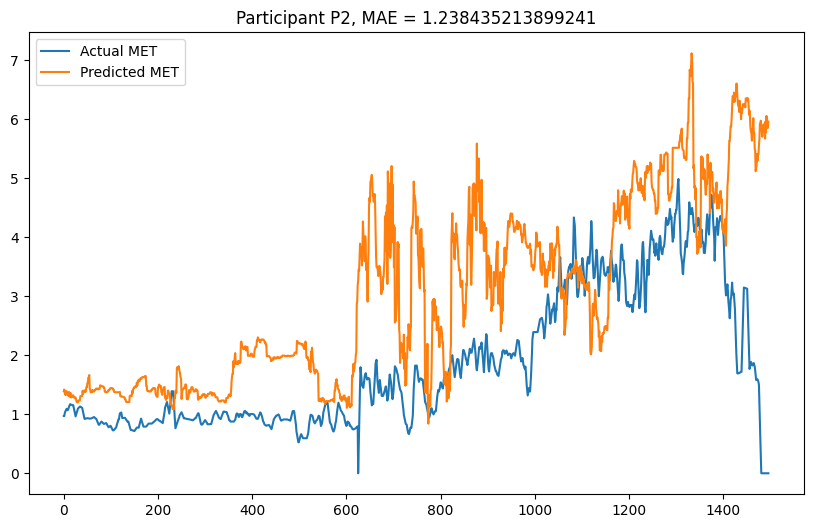

P1
Learning rate set to 0.06844
0:	learn: 2.1020671	total: 11.7ms	remaining: 11.7s
1:	learn: 2.0245753	total: 21.1ms	remaining: 10.6s
2:	learn: 1.9544496	total: 31.1ms	remaining: 10.3s
3:	learn: 1.8900392	total: 43.1ms	remaining: 10.7s
4:	learn: 1.8329626	total: 52.5ms	remaining: 10.5s
5:	learn: 1.7799962	total: 61.8ms	remaining: 10.2s
6:	learn: 1.7352295	total: 71.5ms	remaining: 10.1s
7:	learn: 1.6932392	total: 82ms	remaining: 10.2s
8:	learn: 1.6563476	total: 91.5ms	remaining: 10.1s
9:	learn: 1.6232262	total: 101ms	remaining: 10s
10:	learn: 1.5938805	total: 111ms	remaining: 9.95s
11:	learn: 1.5668977	total: 121ms	remaining: 9.93s
12:	learn: 1.5433866	total: 131ms	remaining: 9.92s
13:	learn: 1.5227478	total: 141ms	remaining: 9.91s
14:	learn: 1.5043790	total: 153ms	remaining: 10.1s
15:	learn: 1.4872497	total: 169ms	remaining: 10.4s
16:	learn: 1.4726471	total: 180ms	remaining: 10.4s
17:	learn: 1.4589902	total: 189ms	remaining: 10.3s
18:	learn: 1.4478825	total: 198ms	remaining: 10.2s
19:	

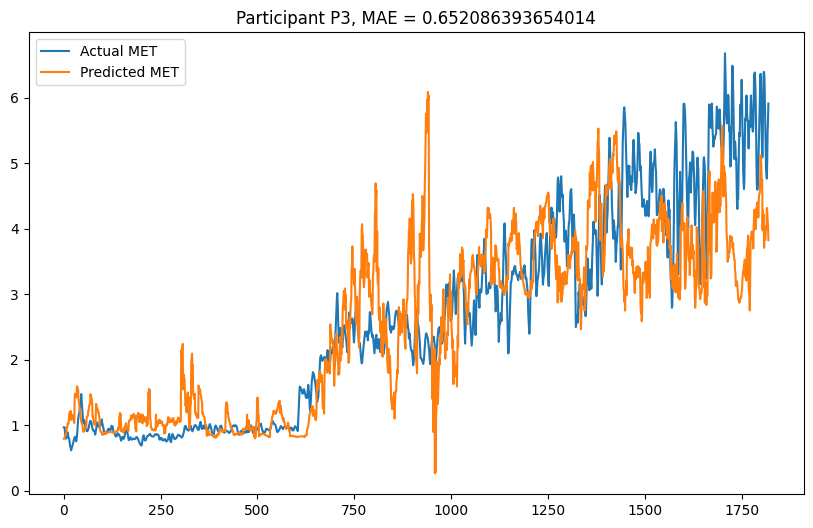

P1
Learning rate set to 0.068482
0:	learn: 2.0621741	total: 11.1ms	remaining: 11.1s
1:	learn: 1.9859974	total: 24.4ms	remaining: 12.2s
2:	learn: 1.9174830	total: 34.6ms	remaining: 11.5s
3:	learn: 1.8548439	total: 46.4ms	remaining: 11.6s
4:	learn: 1.7976522	total: 58.2ms	remaining: 11.6s
5:	learn: 1.7451902	total: 67.8ms	remaining: 11.2s
6:	learn: 1.7013251	total: 77.9ms	remaining: 11.1s
7:	learn: 1.6601590	total: 87.8ms	remaining: 10.9s
8:	learn: 1.6238983	total: 97.5ms	remaining: 10.7s
9:	learn: 1.5912541	total: 107ms	remaining: 10.6s
10:	learn: 1.5619763	total: 117ms	remaining: 10.6s
11:	learn: 1.5366882	total: 127ms	remaining: 10.5s
12:	learn: 1.5129666	total: 137ms	remaining: 10.4s
13:	learn: 1.4922416	total: 147ms	remaining: 10.3s
14:	learn: 1.4744311	total: 156ms	remaining: 10.3s
15:	learn: 1.4575386	total: 178ms	remaining: 11s
16:	learn: 1.4425500	total: 189ms	remaining: 10.9s
17:	learn: 1.4294329	total: 201ms	remaining: 10.9s
18:	learn: 1.4183102	total: 214ms	remaining: 11s
19:

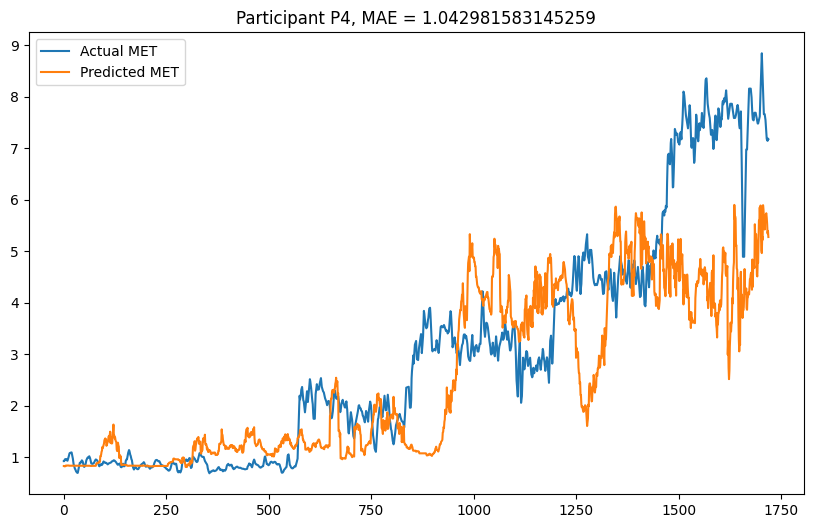

P1
Learning rate set to 0.068511
0:	learn: 2.0865938	total: 13.3ms	remaining: 13.3s
1:	learn: 2.0092536	total: 23.1ms	remaining: 11.5s
2:	learn: 1.9390555	total: 33.4ms	remaining: 11.1s
3:	learn: 1.8744303	total: 45.3ms	remaining: 11.3s
4:	learn: 1.8166386	total: 55.8ms	remaining: 11.1s
5:	learn: 1.7640286	total: 67.3ms	remaining: 11.2s
6:	learn: 1.7190190	total: 77ms	remaining: 10.9s
7:	learn: 1.6775304	total: 86.7ms	remaining: 10.7s
8:	learn: 1.6411236	total: 96.9ms	remaining: 10.7s
9:	learn: 1.6077489	total: 107ms	remaining: 10.6s
10:	learn: 1.5782364	total: 117ms	remaining: 10.5s
11:	learn: 1.5515213	total: 127ms	remaining: 10.4s
12:	learn: 1.5276411	total: 142ms	remaining: 10.8s
13:	learn: 1.5064089	total: 154ms	remaining: 10.8s
14:	learn: 1.4880800	total: 164ms	remaining: 10.8s
15:	learn: 1.4707732	total: 174ms	remaining: 10.7s
16:	learn: 1.4556185	total: 184ms	remaining: 10.7s
17:	learn: 1.4419259	total: 194ms	remaining: 10.6s
18:	learn: 1.4309894	total: 203ms	remaining: 10.5s
1

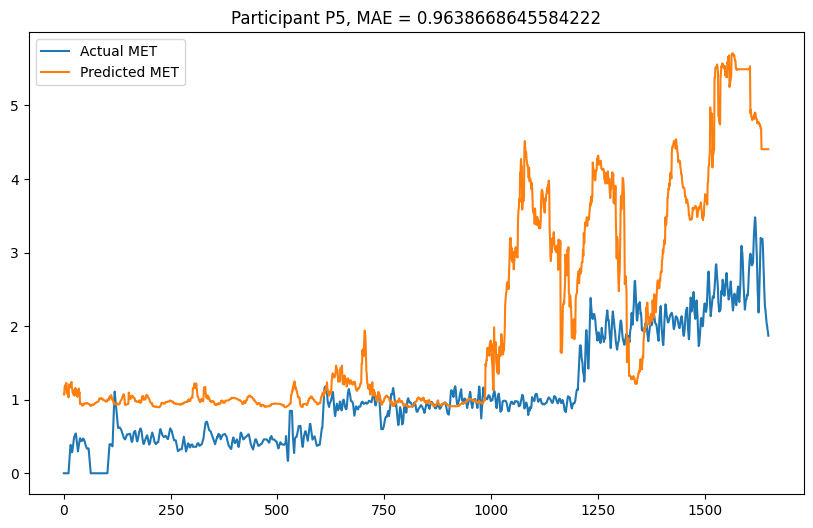

P1
Learning rate set to 0.06845
0:	learn: 2.0993562	total: 10.8ms	remaining: 10.7s
1:	learn: 2.0194522	total: 20ms	remaining: 9.98s
2:	learn: 1.9476090	total: 29.7ms	remaining: 9.86s
3:	learn: 1.8824196	total: 39.1ms	remaining: 9.74s
4:	learn: 1.8232848	total: 49.3ms	remaining: 9.8s
5:	learn: 1.7690133	total: 59.1ms	remaining: 9.79s
6:	learn: 1.7218397	total: 68.5ms	remaining: 9.72s
7:	learn: 1.6785743	total: 77.8ms	remaining: 9.65s
8:	learn: 1.6395453	total: 87ms	remaining: 9.58s
9:	learn: 1.6054790	total: 96.6ms	remaining: 9.56s
10:	learn: 1.5752867	total: 106ms	remaining: 9.53s
11:	learn: 1.5486590	total: 116ms	remaining: 9.52s
12:	learn: 1.5241928	total: 125ms	remaining: 9.45s
13:	learn: 1.5029171	total: 134ms	remaining: 9.45s
14:	learn: 1.4835713	total: 143ms	remaining: 9.41s
15:	learn: 1.4658266	total: 153ms	remaining: 9.38s
16:	learn: 1.4503491	total: 178ms	remaining: 10.3s
17:	learn: 1.4365156	total: 188ms	remaining: 10.3s
18:	learn: 1.4240723	total: 198ms	remaining: 10.2s
19:	

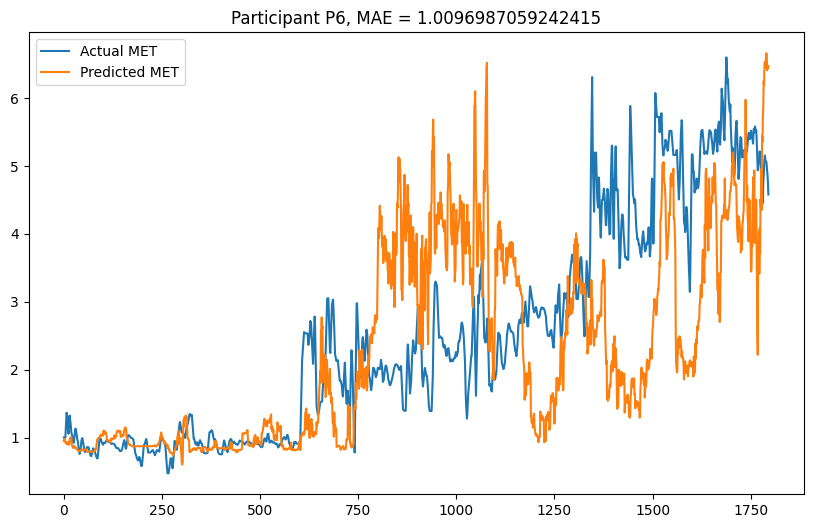

P1
Learning rate set to 0.068487
0:	learn: 2.0903223	total: 12.3ms	remaining: 12.3s
1:	learn: 2.0126250	total: 24.1ms	remaining: 12s
2:	learn: 1.9430145	total: 34.2ms	remaining: 11.4s
3:	learn: 1.8798129	total: 45.1ms	remaining: 11.2s
4:	learn: 1.8225969	total: 55.3ms	remaining: 11s
5:	learn: 1.7697785	total: 64.9ms	remaining: 10.8s
6:	learn: 1.7242527	total: 74.9ms	remaining: 10.6s
7:	learn: 1.6826928	total: 84.5ms	remaining: 10.5s
8:	learn: 1.6451711	total: 94.5ms	remaining: 10.4s
9:	learn: 1.6117255	total: 104ms	remaining: 10.3s
10:	learn: 1.5818121	total: 114ms	remaining: 10.3s
11:	learn: 1.5565062	total: 124ms	remaining: 10.2s
12:	learn: 1.5335494	total: 133ms	remaining: 10.1s
13:	learn: 1.5126836	total: 155ms	remaining: 10.9s
14:	learn: 1.4947959	total: 183ms	remaining: 12s
15:	learn: 1.4777724	total: 194ms	remaining: 12s
16:	learn: 1.4627505	total: 204ms	remaining: 11.8s
17:	learn: 1.4496642	total: 214ms	remaining: 11.7s
18:	learn: 1.4379006	total: 225ms	remaining: 11.6s
19:	lea

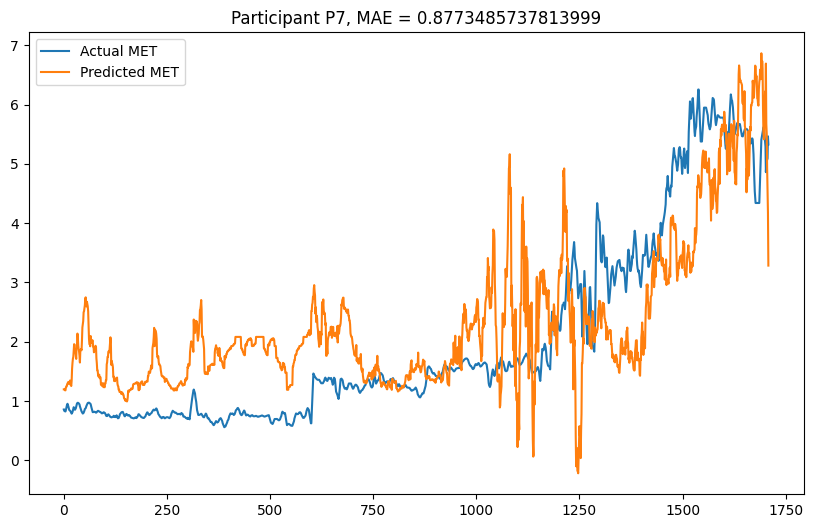

P1
Learning rate set to 0.068551
0:	learn: 2.0654460	total: 11.4ms	remaining: 11.4s
1:	learn: 1.9890371	total: 20.4ms	remaining: 10.2s
2:	learn: 1.9195892	total: 30.1ms	remaining: 10s
3:	learn: 1.8558090	total: 39.2ms	remaining: 9.77s
4:	learn: 1.7980469	total: 48.5ms	remaining: 9.65s
5:	learn: 1.7461249	total: 57.6ms	remaining: 9.54s
6:	learn: 1.7011595	total: 67ms	remaining: 9.5s
7:	learn: 1.6592742	total: 76.7ms	remaining: 9.51s
8:	learn: 1.6229534	total: 86.3ms	remaining: 9.5s
9:	learn: 1.5906015	total: 95.8ms	remaining: 9.49s
10:	learn: 1.5616099	total: 105ms	remaining: 9.48s
11:	learn: 1.5354393	total: 115ms	remaining: 9.47s
12:	learn: 1.5118390	total: 125ms	remaining: 9.47s
13:	learn: 1.4915424	total: 134ms	remaining: 9.47s
14:	learn: 1.4733519	total: 144ms	remaining: 9.46s
15:	learn: 1.4565280	total: 153ms	remaining: 9.44s
16:	learn: 1.4417239	total: 178ms	remaining: 10.3s
17:	learn: 1.4286155	total: 189ms	remaining: 10.3s
18:	learn: 1.4169141	total: 198ms	remaining: 10.2s
19:	

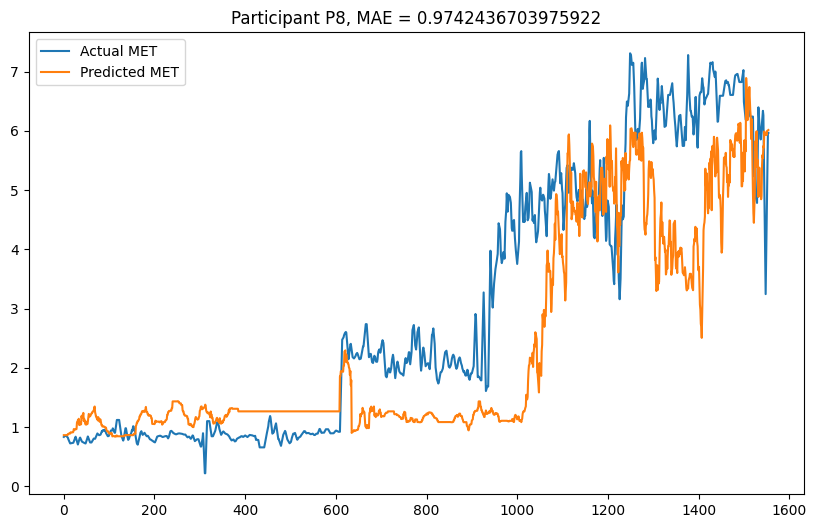

P1
Learning rate set to 0.068631
0:	learn: 2.1026463	total: 13ms	remaining: 13s
1:	learn: 2.0219986	total: 22.7ms	remaining: 11.3s
2:	learn: 1.9490821	total: 32.5ms	remaining: 10.8s
3:	learn: 1.8815122	total: 46.2ms	remaining: 11.5s
4:	learn: 1.8198068	total: 67.8ms	remaining: 13.5s
5:	learn: 1.7638273	total: 77.4ms	remaining: 12.8s
6:	learn: 1.7160220	total: 87.1ms	remaining: 12.4s
7:	learn: 1.6718450	total: 97ms	remaining: 12s
8:	learn: 1.6325892	total: 106ms	remaining: 11.7s
9:	learn: 1.5977882	total: 117ms	remaining: 11.6s
10:	learn: 1.5660362	total: 131ms	remaining: 11.8s
11:	learn: 1.5373695	total: 153ms	remaining: 12.6s
12:	learn: 1.5120888	total: 162ms	remaining: 12.3s
13:	learn: 1.4897677	total: 172ms	remaining: 12.1s
14:	learn: 1.4698298	total: 181ms	remaining: 11.9s
15:	learn: 1.4508980	total: 190ms	remaining: 11.7s
16:	learn: 1.4348536	total: 200ms	remaining: 11.6s
17:	learn: 1.4214421	total: 210ms	remaining: 11.4s
18:	learn: 1.4093988	total: 219ms	remaining: 11.3s
19:	lear

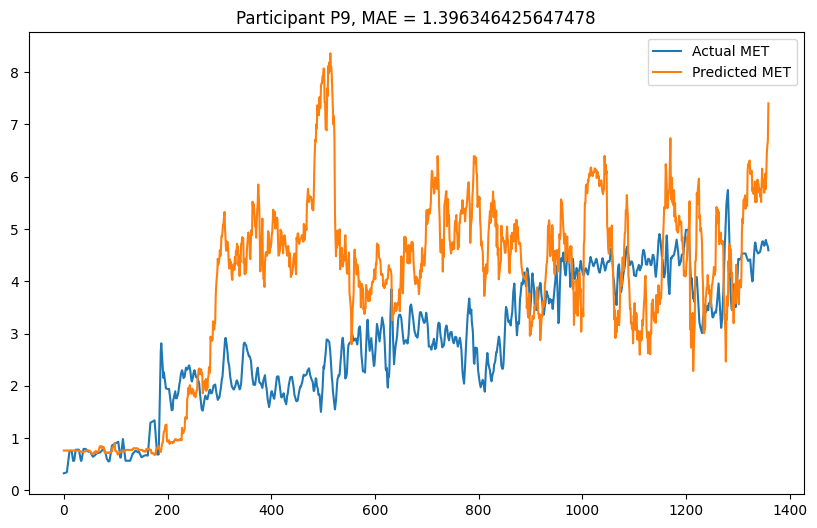

P1
Learning rate set to 0.068463
0:	learn: 2.0937126	total: 10.4ms	remaining: 10.4s
1:	learn: 2.0177181	total: 20.3ms	remaining: 10.1s
2:	learn: 1.9487559	total: 30.5ms	remaining: 10.1s
3:	learn: 1.8844196	total: 40.2ms	remaining: 10s
4:	learn: 1.8279749	total: 50ms	remaining: 9.95s
5:	learn: 1.7756385	total: 70.6ms	remaining: 11.7s
6:	learn: 1.7314735	total: 80.6ms	remaining: 11.4s
7:	learn: 1.6894603	total: 90.2ms	remaining: 11.2s
8:	learn: 1.6530134	total: 99.6ms	remaining: 11s
9:	learn: 1.6206014	total: 109ms	remaining: 10.8s
10:	learn: 1.5917652	total: 119ms	remaining: 10.7s
11:	learn: 1.5650998	total: 128ms	remaining: 10.5s
12:	learn: 1.5408940	total: 137ms	remaining: 10.4s
13:	learn: 1.5206104	total: 148ms	remaining: 10.4s
14:	learn: 1.5029156	total: 162ms	remaining: 10.6s
15:	learn: 1.4858381	total: 186ms	remaining: 11.5s
16:	learn: 1.4710034	total: 196ms	remaining: 11.3s
17:	learn: 1.4572037	total: 205ms	remaining: 11.2s
18:	learn: 1.4453083	total: 215ms	remaining: 11.1s
19:	l

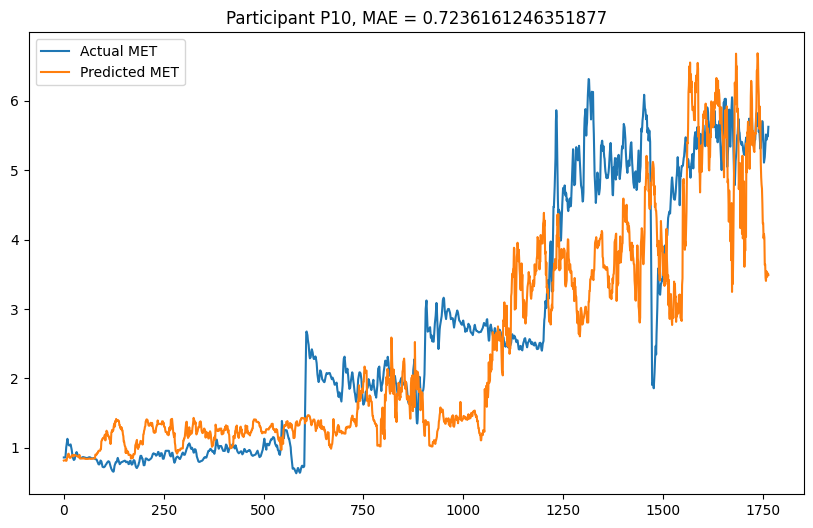

P1
Learning rate set to 0.068485
0:	learn: 1.9817544	total: 10.3ms	remaining: 10.3s
1:	learn: 1.9067822	total: 19ms	remaining: 9.49s
2:	learn: 1.8385205	total: 31.6ms	remaining: 10.5s
3:	learn: 1.7772423	total: 40.5ms	remaining: 10.1s
4:	learn: 1.7213648	total: 49.2ms	remaining: 9.79s
5:	learn: 1.6709301	total: 57.6ms	remaining: 9.55s
6:	learn: 1.6267499	total: 66.1ms	remaining: 9.38s
7:	learn: 1.5864467	total: 74.9ms	remaining: 9.28s
8:	learn: 1.5509470	total: 83.3ms	remaining: 9.17s
9:	learn: 1.5178683	total: 91.8ms	remaining: 9.09s
10:	learn: 1.4888802	total: 100ms	remaining: 9.01s
11:	learn: 1.4632852	total: 109ms	remaining: 8.97s
12:	learn: 1.4401051	total: 118ms	remaining: 8.94s
13:	learn: 1.4193407	total: 129ms	remaining: 9.06s
14:	learn: 1.4011896	total: 154ms	remaining: 10.1s
15:	learn: 1.3844033	total: 164ms	remaining: 10.1s
16:	learn: 1.3691770	total: 174ms	remaining: 10.1s
17:	learn: 1.3561520	total: 183ms	remaining: 10s
18:	learn: 1.3451285	total: 192ms	remaining: 9.91s
19

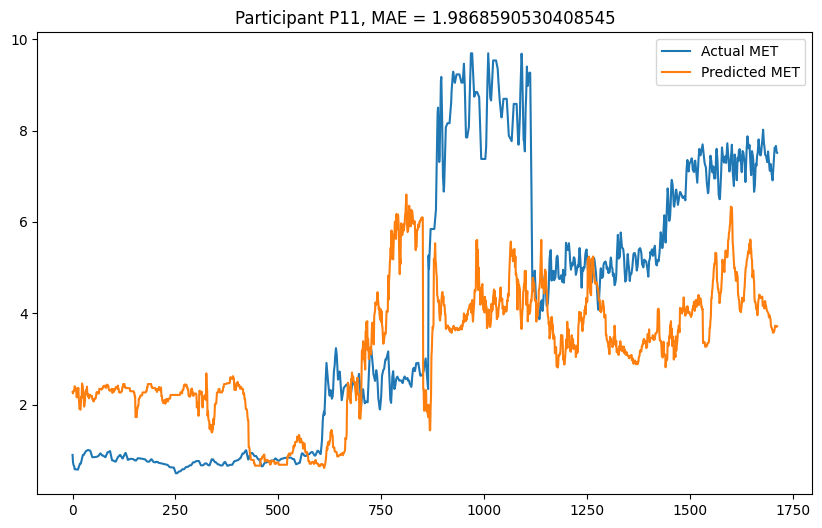

P1
Learning rate set to 0.068448
0:	learn: 2.0951243	total: 10ms	remaining: 9.99s
1:	learn: 2.0174423	total: 19.1ms	remaining: 9.53s
2:	learn: 1.9473240	total: 28.7ms	remaining: 9.53s
3:	learn: 1.8836843	total: 37.7ms	remaining: 9.4s
4:	learn: 1.8247880	total: 46.8ms	remaining: 9.32s
5:	learn: 1.7720075	total: 56ms	remaining: 9.28s
6:	learn: 1.7258339	total: 65.5ms	remaining: 9.29s
7:	learn: 1.6828956	total: 74.4ms	remaining: 9.23s
8:	learn: 1.6452694	total: 83.4ms	remaining: 9.19s
9:	learn: 1.6111855	total: 92.5ms	remaining: 9.15s
10:	learn: 1.5808723	total: 101ms	remaining: 9.11s
11:	learn: 1.5538568	total: 111ms	remaining: 9.1s
12:	learn: 1.5300284	total: 120ms	remaining: 9.09s
13:	learn: 1.5086782	total: 129ms	remaining: 9.07s
14:	learn: 1.4891965	total: 138ms	remaining: 9.03s
15:	learn: 1.4715636	total: 146ms	remaining: 8.99s
16:	learn: 1.4561791	total: 157ms	remaining: 9.08s
17:	learn: 1.4424555	total: 171ms	remaining: 9.35s
18:	learn: 1.4303476	total: 191ms	remaining: 9.84s
19:	

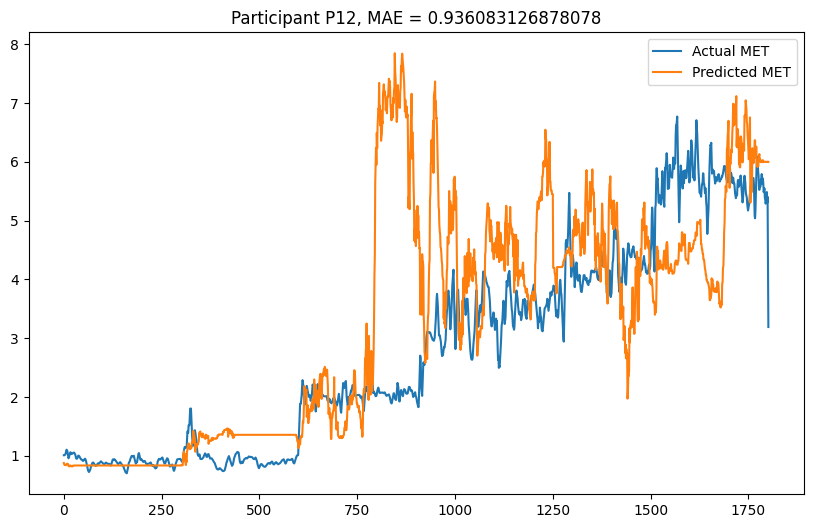

P1
Learning rate set to 0.068828
0:	learn: 2.0868043	total: 11.7ms	remaining: 11.6s
1:	learn: 2.0096784	total: 21.3ms	remaining: 10.6s
2:	learn: 1.9403562	total: 31.4ms	remaining: 10.4s
3:	learn: 1.8772630	total: 41ms	remaining: 10.2s
4:	learn: 1.8195419	total: 50.8ms	remaining: 10.1s
5:	learn: 1.7673566	total: 60.5ms	remaining: 10s
6:	learn: 1.7231460	total: 70.1ms	remaining: 9.94s
7:	learn: 1.6814626	total: 79.6ms	remaining: 9.87s
8:	learn: 1.6436652	total: 88.9ms	remaining: 9.79s
9:	learn: 1.6112820	total: 111ms	remaining: 11s
10:	learn: 1.5824638	total: 127ms	remaining: 11.5s
11:	learn: 1.5570677	total: 137ms	remaining: 11.3s
12:	learn: 1.5329413	total: 146ms	remaining: 11.1s
13:	learn: 1.5126845	total: 156ms	remaining: 11s
14:	learn: 1.4944247	total: 165ms	remaining: 10.8s
15:	learn: 1.4774783	total: 175ms	remaining: 10.8s
16:	learn: 1.4627298	total: 185ms	remaining: 10.7s
17:	learn: 1.4495697	total: 195ms	remaining: 10.6s
18:	learn: 1.4387928	total: 205ms	remaining: 10.6s
19:	lea

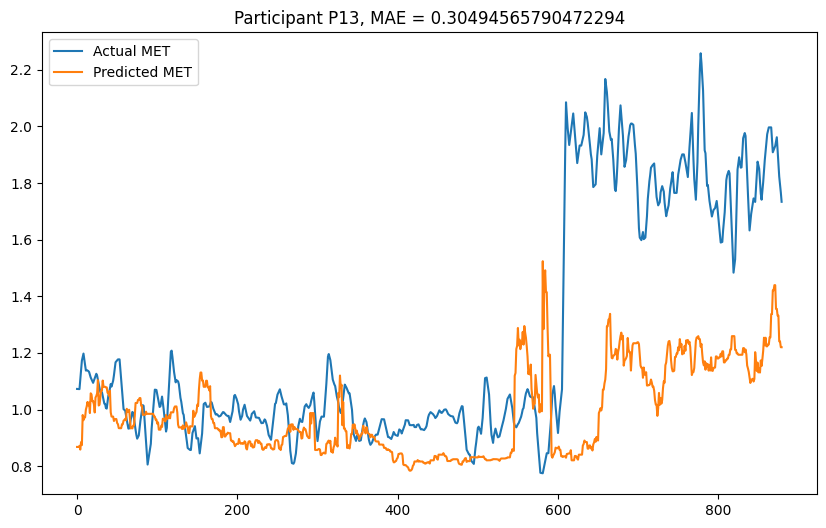

P1
Learning rate set to 0.068549
0:	learn: 2.0358014	total: 10.8ms	remaining: 10.7s
1:	learn: 1.9599272	total: 20.1ms	remaining: 10s
2:	learn: 1.8907558	total: 29.8ms	remaining: 9.89s
3:	learn: 1.8278121	total: 39.7ms	remaining: 9.88s
4:	learn: 1.7709925	total: 49.4ms	remaining: 9.82s
5:	learn: 1.7188795	total: 59ms	remaining: 9.77s
6:	learn: 1.6740001	total: 68.6ms	remaining: 9.74s
7:	learn: 1.6330208	total: 78.3ms	remaining: 9.7s
8:	learn: 1.5969992	total: 88.2ms	remaining: 9.71s
9:	learn: 1.5643838	total: 99ms	remaining: 9.8s
10:	learn: 1.5349702	total: 109ms	remaining: 9.84s
11:	learn: 1.5086456	total: 119ms	remaining: 9.81s
12:	learn: 1.4850003	total: 130ms	remaining: 9.83s
13:	learn: 1.4643933	total: 140ms	remaining: 9.83s
14:	learn: 1.4463565	total: 150ms	remaining: 9.87s
15:	learn: 1.4291081	total: 169ms	remaining: 10.4s
16:	learn: 1.4148055	total: 184ms	remaining: 10.6s
17:	learn: 1.4017568	total: 199ms	remaining: 10.9s
18:	learn: 1.3909242	total: 210ms	remaining: 10.8s
19:	le

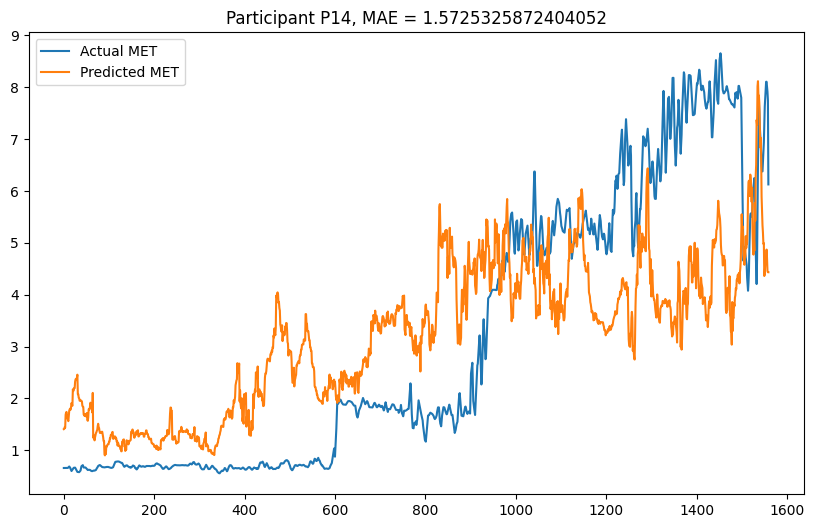

P1
Learning rate set to 0.068697
0:	learn: 2.0708105	total: 11.3ms	remaining: 11.3s
1:	learn: 1.9930660	total: 20.4ms	remaining: 10.2s
2:	learn: 1.9232141	total: 30.2ms	remaining: 10s
3:	learn: 1.8591706	total: 40ms	remaining: 9.96s
4:	learn: 1.8003087	total: 49.5ms	remaining: 9.86s
5:	learn: 1.7474642	total: 59.2ms	remaining: 9.8s
6:	learn: 1.7009533	total: 68.9ms	remaining: 9.77s
7:	learn: 1.6587206	total: 78.8ms	remaining: 9.77s
8:	learn: 1.6217594	total: 88.1ms	remaining: 9.7s
9:	learn: 1.5885018	total: 97.7ms	remaining: 9.68s
10:	learn: 1.5586019	total: 107ms	remaining: 9.62s
11:	learn: 1.5317154	total: 116ms	remaining: 9.59s
12:	learn: 1.5078667	total: 126ms	remaining: 9.56s
13:	learn: 1.4870411	total: 140ms	remaining: 9.86s
14:	learn: 1.4677692	total: 155ms	remaining: 10.2s
15:	learn: 1.4503884	total: 176ms	remaining: 10.8s
16:	learn: 1.4345602	total: 186ms	remaining: 10.7s
17:	learn: 1.4214679	total: 195ms	remaining: 10.6s
18:	learn: 1.4101008	total: 204ms	remaining: 10.5s
19:	

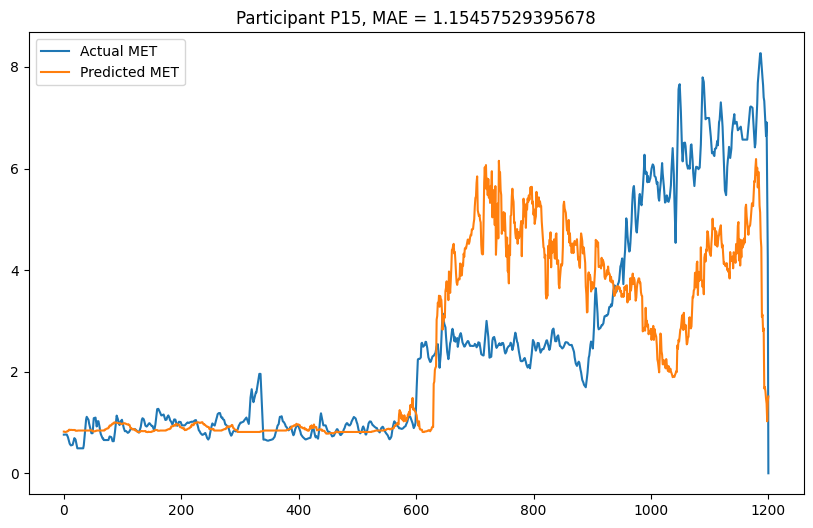

P1
Learning rate set to 0.068448
0:	learn: 1.9802225	total: 10.3ms	remaining: 10.3s
1:	learn: 1.9092051	total: 19.5ms	remaining: 9.73s
2:	learn: 1.8446481	total: 29.3ms	remaining: 9.73s
3:	learn: 1.7859062	total: 38.4ms	remaining: 9.55s
4:	learn: 1.7331070	total: 46.8ms	remaining: 9.31s
5:	learn: 1.6843274	total: 55.6ms	remaining: 9.21s
6:	learn: 1.6419060	total: 64.6ms	remaining: 9.16s
7:	learn: 1.6036673	total: 73.7ms	remaining: 9.14s
8:	learn: 1.5703632	total: 82.7ms	remaining: 9.1s
9:	learn: 1.5399940	total: 92ms	remaining: 9.11s
10:	learn: 1.5125825	total: 101ms	remaining: 9.08s
11:	learn: 1.4889810	total: 110ms	remaining: 9.05s
12:	learn: 1.4664150	total: 119ms	remaining: 9.02s
13:	learn: 1.4477909	total: 128ms	remaining: 9.02s
14:	learn: 1.4303267	total: 137ms	remaining: 9s
15:	learn: 1.4142419	total: 146ms	remaining: 8.99s
16:	learn: 1.4007375	total: 159ms	remaining: 9.21s
17:	learn: 1.3879272	total: 184ms	remaining: 10.1s
18:	learn: 1.3767861	total: 199ms	remaining: 10.3s
19:	

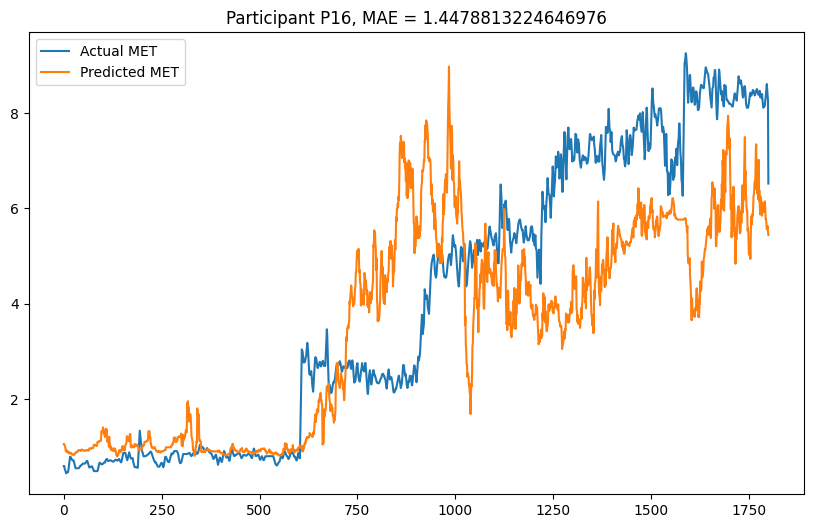

In [ ]:
# print(cv)
mae_list_catboost = []
for fold, participant in enumerate(cv):
    train_index, test_index = participant
    print(people[fold])

    X_train, X_test = X_data[train_index], X_data[test_index]
    Y_train, Y_test = Y_data[train_index], Y_data[test_index]

    model.fit(X_train, Y_train)
    Y_pred = model.predict(X_test)

    mae = mean_absolute_error(Y_test, Y_pred)
    mae_list_catboost.append((fold + 1,mae))

    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='Actual MET')
    plt.plot(Y_pred, label='Predicted MET')
    plt.title('Participant P{}, MAE = {}'.format(fold, mae))
    plt.legend()
    plt.show()


|  | CatBoost | XGBoost |
|----------|----------|----------|
| Parameters (before lag feature and tsfresh) | Row 1, Col 2 | |
| Parameters (after lag feature and tsfresh) | Row 1, Col 2 |learning_rate = 0.01, max_depth = 2, n_estimators = 500 |




|  | CatBoost | XGBoost |
|----------|----------|----------|
| MAE (before lag feature and tsfresh) | Row 2, Col 2 |Row 1, Col 2 |
| MAE (after lag feature and no tsfresh) | 1.05408 |1.05543 |
| MAE (after lag feature and tsfresh) | 1.05408 |1.05543 |

In [ ]:
mae_list_catboost

[(1, 1.3248045947154496),
 (2, 1.0208701976051224),
 (3, 1.238435213899241),
 (4, 0.652086393654014),
 (5, 1.042981583145259),
 (6, 0.9638668645584222),
 (7, 1.0096987059242415),
 (8, 0.8773485737813999),
 (9, 0.9742436703975922),
 (10, 1.396346425647478),
 (11, 0.7236161246351877),
 (12, 1.9868590530408545),
 (13, 0.936083126878078),
 (14, 0.30494565790472294),
 (15, 1.5725325872404052),
 (16, 1.15457529395678),
 (17, 1.4478813224646976)]

| XGBoost | P1 | P2 | P3 | P4 | P5 | P6 | P7 | P8 | P9 | P10 | P11 | P12 | P13 | P14 | P15 | P16 | P17 | average |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| MAE (after lag feature only) | 1.4708 | 1.1151 | 1.3711 | 0.7630 | 1.1078 | 0.9686 | 1.0505 | 0.9399 | 1.0398 | 1.4662 | 0.7943 | 2.0463 | 1.0281 | 0.2944 | 1.5734 | 1.1331 | 1.4432 | 1.1533 |
| MAE (after lag feature and tsfresh) | 1.4532 | 1.0925 | 1.3297 | 0.7042 | 1.1196 | 0.9894 | 1.0624 | 0.9332 | 1.0337 | 1.5321 | 0.7913 | 1.9842 | 1.0466 | 0.2943 | 1.5984 | 1.1403 | 1.4766 | 1.1519 |

| CatBoost | P1 | P2 | P3 | P4 | P5 | P6 | P7 | P8 | P9 | P10 | P11 | P12 | P13 | P14 | P15 | P16 | P17 | average |
|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|----------|
| MAE (after lag feature only) | 1.3656 | 1.0485 | 1.2432 | 0.6463 | 1.0378 | 0.9633 | 0.9973 | 0.8582 | 0.9770 | 1.3932 | 0.7225 | 1.9850 | 0.9277 | 0.3034 | 1.5755 | 1.1516 | 1.4395 | 1.0962 |
| MAE (after lag feature and tsfresh) | 1.3248 | 1.0209 | 1.2384 |  0.6521 | 1.0430 | 0.9639  | 1.0097 | 0.8773 | 0.9742 | 1.3963 | 0.7236 | 1.9869 | 0.9361 | 0.3049 | 1.5725 | 1.1546 | 1.4479 | 1.0957 |

In [7]:
mae_list_xgboost
averages = tuple(sum(col) / len(mae_list_xgboost) for col in zip(*mae_list_xgboost))
print("Averages:", averages)


Averages: (9.0, 1.1518641602855262)


In [6]:
mae_list_catboost
averages = tuple(sum(col) / len(mae_list_catboost) for col in zip(*mae_list_catboost))
print("Averages:", averages)


Averages: (9.0, 1.0957161993793498)
